# Classification of images

In [1]:
import nbimporter
from benchmark import ImageTags
from classifiers import Classifier, Supervised, Unsupervised
import numpy as np
from IPython.core.display import display, HTML, Image
import scipy.spatial.distance as dis
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from sklearn import metrics
import sklearn.cluster as cls

importing Jupyter notebook from benchmark.ipynb
importing Jupyter notebook from classifiers.ipynb


In [2]:
def cm_plot(ax, classes, CM, title, figure):
    im = ax.imshow(CM, interpolation='nearest', cmap=plt.cm.Blues)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    figure.colorbar(im, cax=cax, orientation='vertical')
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90, fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=0, fontsize=12)
    ax.set_title(title, fontsize=16)
    thresh = CM.max() / 2.
    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        ax.text(j, i, CM[i, j], horizontalalignment="center",
                 color="white" if CM[i, j] > thresh else "black", fontsize=12)
    ax.set_ylabel('True label', fontsize=16)
    ax.set_xlabel('Predicted label', fontsize=16)

# SUPERVISED METHODS

In [3]:
I = ImageTags('inforet', 'googleimages', url='image_thumbnail_url', 
              selection=None)
S = Supervised(I, 'category')

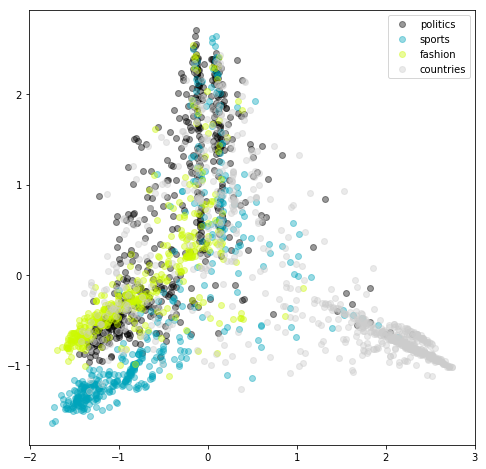

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
S.show(axes)
plt.legend()
plt.show()

In [5]:
display(HTML(S.show_sample()))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


## Supervised classification

In [6]:
train, train_categories, test, test_categories, train_docs, test_docs = S.train_test()

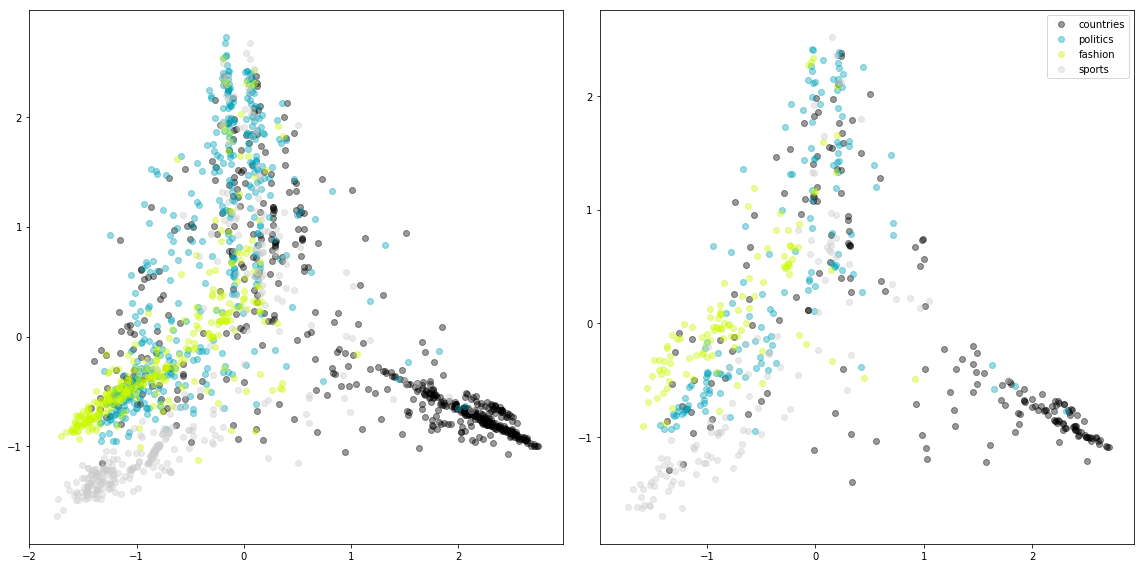

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
S.show(axes[0], data=train, categories=train_categories)
S.show(axes[1], data=test, categories=test_categories)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
methods = [
    ('Gaussian NB', S.gaussian),
    ('Bernoulli NB', S.bernoulli),
    ('Multinomial NB', S.multinomial),
    ('Support Vector Machine', S.svc),
    ('KNN', S.knn)
]

### Train & predict

In [9]:
predicted, cms = [], []
labels = list(set(test_categories))
for method_name, method in methods:
    S.train(train, train_categories, method)
    p = S.predict(test, method)
    predicted.append(p)
    cms.append(metrics.confusion_matrix(test_categories, p, labels=labels))

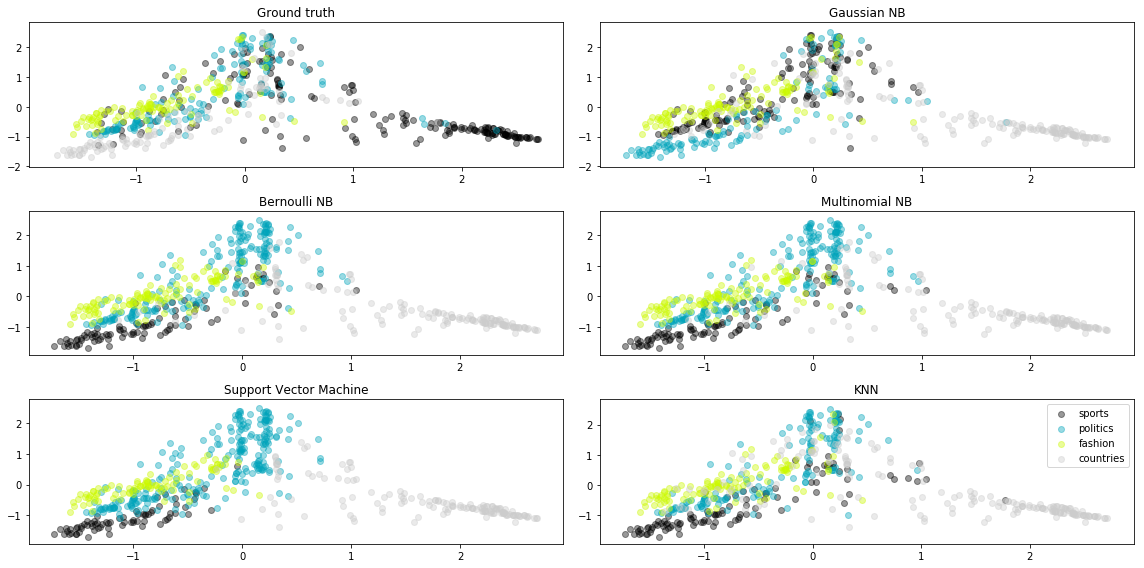

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 8))
S.show(axes[0, 0], data=test, categories=test_categories)
axes[0, 0].set_title('Ground truth')
S.show(axes[0, 1], data=test, categories=predicted[0])
axes[0, 1].set_title('Gaussian NB')
S.show(axes[1, 0], data=test, categories=predicted[1])
axes[1, 0].set_title('Bernoulli NB')
S.show(axes[1, 1], data=test, categories=predicted[2])
axes[1, 1].set_title('Multinomial NB')
S.show(axes[2, 0], data=test, categories=predicted[3])
axes[2, 0].set_title('Support Vector Machine')
S.show(axes[2, 1], data=test, categories=predicted[4])
axes[2, 1].set_title('KNN')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
for z, (m,_) in enumerate(methods):
    display(HTML("<h2>{}</h2>".format(m)))
    display(HTML(S.show_sample(docs=test_docs, categories=predicted[z])))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


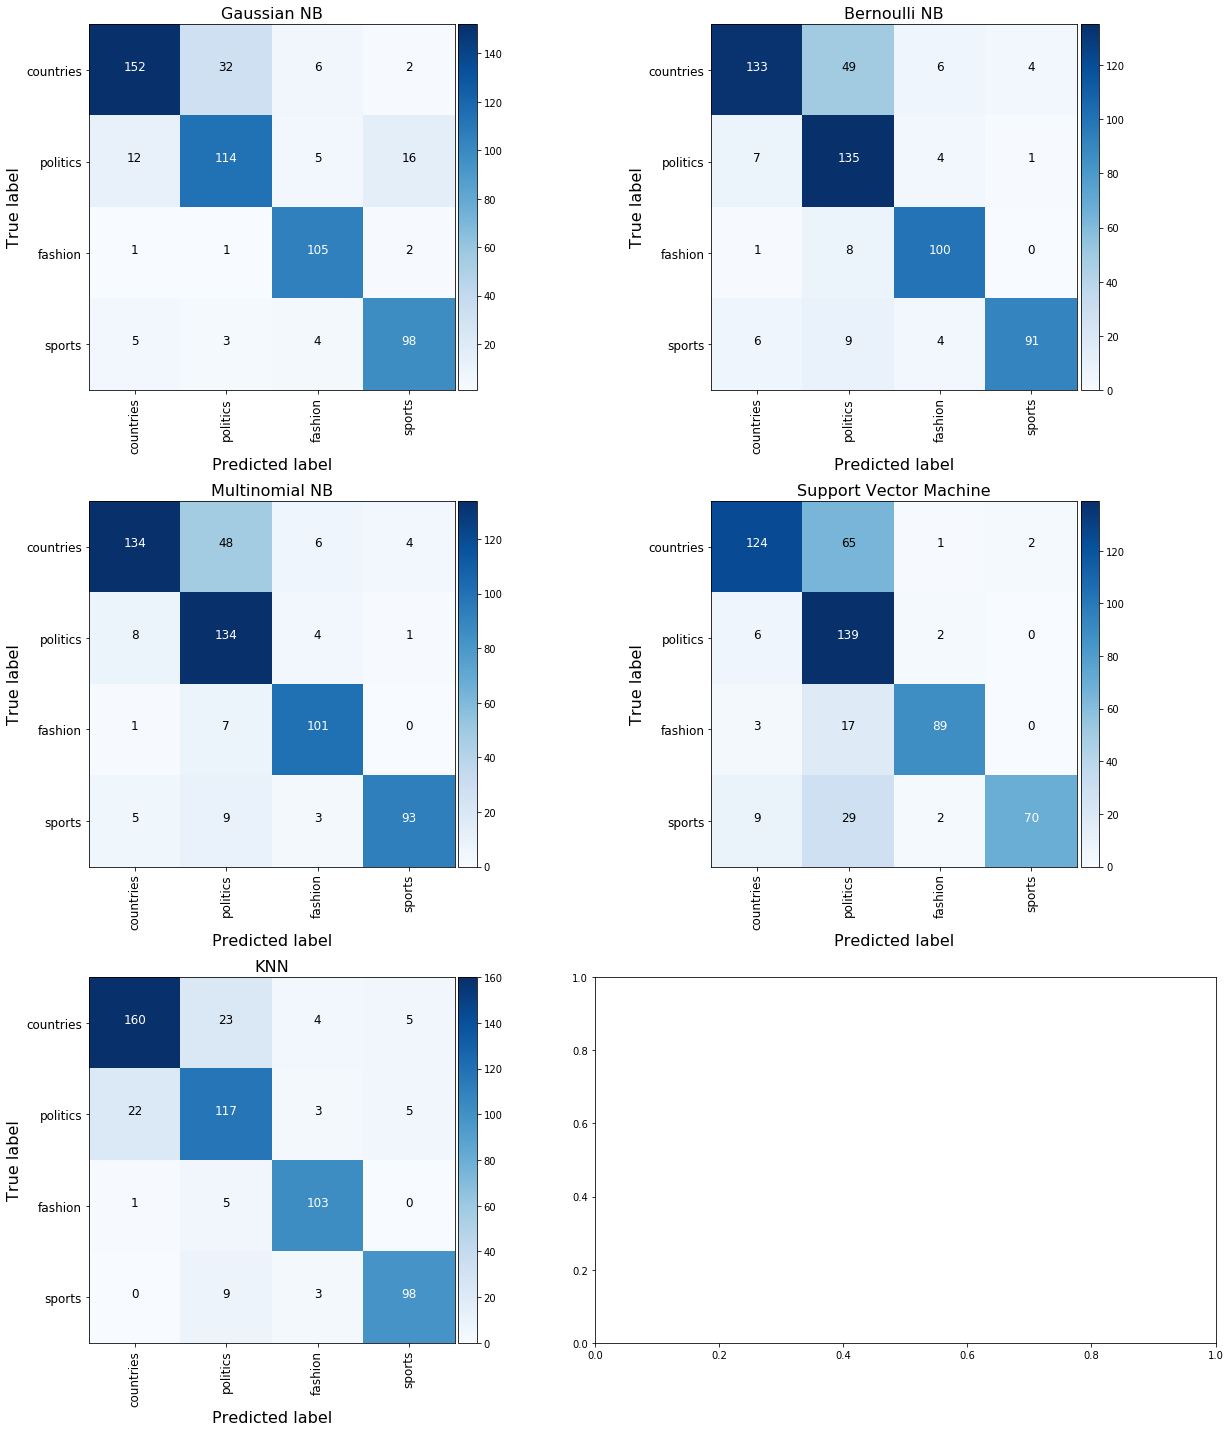

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 20))
cm_plot(axes[0,0], labels, cms[0], 'Gaussian NB', fig)
cm_plot(axes[0,1], labels, cms[1], 'Bernoulli NB', fig)
cm_plot(axes[1,0], labels, cms[2], 'Multinomial NB', fig)
cm_plot(axes[1,1], labels, cms[3], 'Support Vector Machine', fig)
cm_plot(axes[2,0], labels, cms[4], 'KNN', fig)
plt.tight_layout()
plt.show()

In [13]:
m_t = "<table>{}</table>"
m_R = []
for i, (classifier, m) in enumerate(methods):
    cm = cms[i]
    cl_row = "<h3>{}</h3>".format(classifier)
    table_h = "<tr><th>Category</th><th>Precision</th><th>Recall</th></tr>"
    rows = []
    for j, row in enumerate(cm):
        P, R = [], []
        try:
            prec = round(float(row[j]) / row.sum(), 3)
            P.append(prec)
        except ZeroDivisionError:
            prec = np.nan
        try:
            rec = round(float(row[j]) / cm[:,j].sum(), 3)
            R.append(rec)
        except ZeroDivisionError:
            rec = np.nan
        rows.append("<tr><td>{}</td><td>{}</td><td>{}</td></tr>".format(
            labels[j], prec, rec
        ))
    rows.append("<tr><th>Average</th><th>{}</th><th>{}</th></tr>".format(
        np.array(P).mean(), np.array(R).mean()
    ))
    table = "{}<table>{}{}</table>".format(cl_row, table_h, "".join(rows))
    m_R.append(table)
mr1 = "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(
    m_R[0],m_R[1],m_R[2],m_R[3],m_R[4])
m_t = m_t.format("".join([mr1]))
display(HTML(m_t))

Category,Precision,Recall
countries,0.792,0.894
politics,0.776,0.76
fashion,0.963,0.875
sports,0.891,0.831
Average,0.891,0.831
Category,Precision,Recall
countries,0.693,0.905
politics,0.918,0.672
fashion,0.917,0.877
sports,0.827,0.948


# UNSUPERVISED METHODS

In [3]:
K = 4
experiments = ['K-means', 'Ward HClustering', 'Affinity Propagation', 'Mean-shift',
              'Spectral clustering', 'DBSCAN']
classes = [cls.KMeans(n_clusters=K), 
           cls.AgglomerativeClustering(n_clusters=K, linkage='ward'),
           cls.AffinityPropagation(preference=-50), 
           cls.MeanShift(bin_seeding=True),
           cls.SpectralClustering(n_clusters=K),
           cls.DBSCAN(eps=0.5, min_samples=6)]
u_methods = zip(experiments, classes)

In [4]:
I = ImageTags('inforet', 'googleimages', url='image_thumbnail_url', 
              selection=None)
U = Unsupervised(I, 'category', train_size=0.8)
train, train_categories, test, test_categories, train_docs, test_docs = U.train_test()

In [5]:
clusters = []
for l, m in u_methods:
    clusters.append(U.predict(test, m))

In [6]:
print clusters[0][:10]
print test_categories[:10]

[2 2 2 2 2 1 2 0 1 1]
[u'politics', u'politics', u'politics', u'politics', u'politics', u'politics', u'politics', u'politics', u'politics', u'politics']


### Map cluster labels on test labels

In [7]:
from collections import defaultdict

mps = []
for cls in clusters:
    mp = defaultdict(lambda: defaultdict(lambda: 0))
    for ki, kl in enumerate(test_categories):
        cl_l = cls[ki]
        mp[cl_l][kl] += 1
    mps.append(mp)

In [9]:
def apply_map(cls, mp):
    cll = []
    for l in cls:
        cll.append(sorted(mp[l].items(), key=lambda x: -x[1])[0][0])
    return cll

In [10]:
clusters_l = []
for i, c in enumerate(clusters):
    clusters_l.append(apply_map(c, mps[i]))

## No label mapping

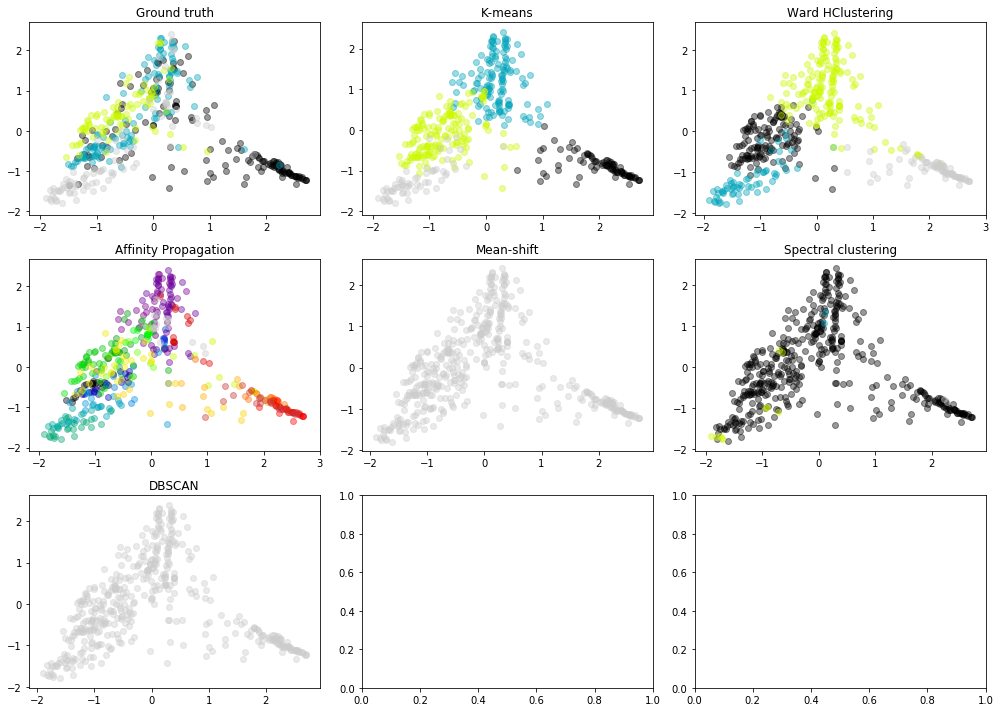

In [11]:
titles = ['Ground truth'] + experiments
models = [test_categories] + clusters
cols = 3
rows = int(np.ceil(float(len(models))/cols))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 10))
for i, labels in enumerate(models):
    U.show(axes[i/cols,i%cols], data=test, categories=labels)
    axes[i/cols,i%cols].set_title(titles[i])
plt.tight_layout()
plt.show()

## Label Mapping

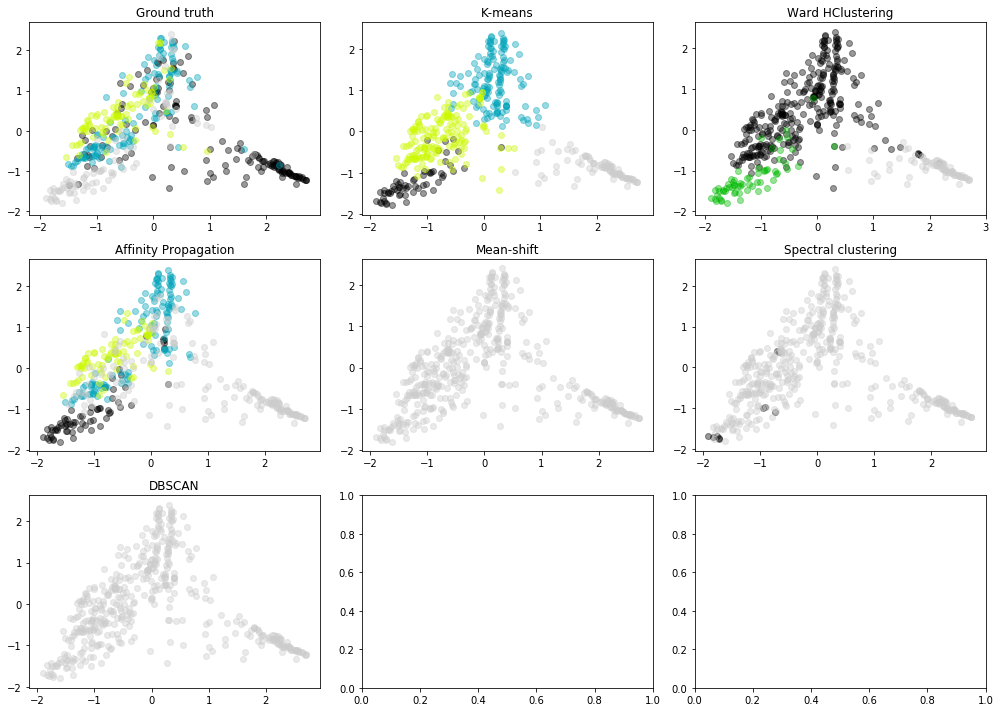

In [12]:
titles = ['Ground truth'] + experiments
models = [test_categories] + clusters_l
cols = 3
rows = int(np.ceil(float(len(models))/cols))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 10))
for i, labels in enumerate(models):
    U.show(axes[i/cols,i%cols], data=test, categories=labels)
    axes[i/cols,i%cols].set_title(titles[i])
plt.tight_layout()
plt.show()

## Cluster-specific evaluation metrics

In [13]:
rows = []
for i, e in enumerate(experiments):
    data = [
        e, 
        round(metrics.adjusted_mutual_info_score(test_categories, clusters[i]), 3),
        round(metrics.adjusted_rand_score(test_categories, clusters[i]), 3),
        round(metrics.homogeneity_score(test_categories, clusters[i]), 3)
    ]
    row = "<tr>" + "".join(["<td>{}</td>".format(x) for x in data]) + "</tr>"
    rows.append(row)
table = "<table>{}</table>".format("".join(rows))
display(HTML(table))

K-means,0.351,0.252,0.356
Ward HClustering,0.326,0.209,0.331
Affinity Propagation,0.26,0.12,0.669
Mean-shift,0.0,0.0,0.0
Spectral clustering,0.018,0.006,0.026
DBSCAN,0.0,0.0,0.0
